##  A 2-Hidden Layer Architecture
What is happening here?
    [1] A traditional ANN model.
    [2] Import and preprocessing data.
    [3] Trigonometric transformations, which converting the original angle plies into sine and cosine values range between -1 and 1 to helps normalize data.
    [4] Create a neural network model with specific hidden layer and the model uses the Sequential API from Keras, starting with an input layer, followed by a dense (fully connected) hidden layer with ReLU activation, and then an output layer with linear activation (for regression tasks).
    [5] Model Training and Evaluation: run over a range of different number of neurons (from 20 to 80 with step of 5) to tune the model's hyperparameters.
    For each number of neurons: A KerasRegressor wrapper is instantiated with the defined neural network model and training settings (epochs, batch size).
    5-Fold Cross-Validation for robust evaluates the model's performance metrics (MSE, MAE, R-squared) on each fold of the data and to avoid overfitting.
    [6] Model Evaluation (mean and standard deviation of performance metrics).
    [7] Plot Mean of(R2, MAE, RMSE) vs number of neurons.

In [1]:
import pandas as pd 
import numpy as np                                             
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.base import TransformerMixin
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold, cross_validate
import matplotlib.patches as mpatches

## Import data
bucklingdata = pd.read_csv("CBL_SimulationResults.csv", encoding='cp1252')

## Convert the hole_column from integer into a floating data type
bucklingdata['Number of holes, nh'] = bucklingdata['Number of holes, nh'].astype('float64')
bucklingdata['Web opening diameter, Do (mm)'] = bucklingdata['Web opening diameter, Do (mm)'].astype('float64')

## Trigonometric transformation of the ply angles: We develop a trigonometric transformation function to convert the angles (this is important)
# Create a transformation class here for the angle plies:
class TrigonometricTransformer(TransformerMixin):
    def __init__(self, start_column=1, end_column=-1):
        self.start_column = start_column
        self.end_column = end_column
        self.transform_functions = [np.sin, np.cos]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        columns_to_transform = X.columns[self.start_column:self.end_column]

        for col in columns_to_transform:
            for func in self.transform_functions:
                X_transformed[col + '_' + func.__name__] = func(X[col])

        # Remove the original columns
        X_transformed.drop(columns=columns_to_transform, inplace=True)

        return X_transformed

# Specify the input and output datasets
input_data = bucklingdata.drop(['Critical Buckling Load (N)','Critical Buckling Load (kN)'], axis=1)
output_data = bucklingdata['Critical Buckling Load (kN)']

# Apply the transformation on the ply columns
transformer = TrigonometricTransformer(start_column=3, end_column=11)
# Transform the input DataFrame
transformed_bucklingdata = transformer.fit_transform(input_data)

# The input dimension for the Neural Network is then obtained as. Then, the input_size will use in following: model.add(Input(shape=(19,)))
input_size = transformed_bucklingdata.shape[1]
#print(input_size)

## Define a specific neural network model with one hidden layer
def create_model2H(neurons_list):
    model = Sequential()
    model.add(Input(shape=(19,)))
    hp_activation = 'selu'
    model.add(Dense(neurons_list[0], activation=hp_activation))
    model.add(Dense(neurons_list[1], activation=hp_activation))
    model.add(Dense(1, activation='linear'))
    hp_learning_rate = 0.01
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=['mae'])
    return model

# Pass the input and output dataframes to X , y (this is just convention in Python ML)
X = transformed_bucklingdata.copy()
y = output_data.copy()

# Specify the range for neurons in the first and second hidden layers
min_neurons = 20
max_neurons = 80
step = 5

neuron_configs = []

# Generate configurations with increasing neurons in both layers
for neurons1 in range(min_neurons, max_neurons + 1, step):
    for neurons2 in range(min_neurons, max_neurons + 1, step):
        neuron_configs.append((neurons1, neurons2))

# Define lists to store results
results = []


for i, (p1, p2) in enumerate(neuron_configs):
    print(f"Training model with configuration {i+1}: Hidden Layer 1={p1}, Hidden Layer 2={p2}")
    
    keras_regressor = KerasRegressor(model=lambda: create_model2H([neurons1, neurons2]), epochs=150, batch_size=32, verbose=0)
    
    # Use cross_val_score to evaluate the model
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(keras_regressor, X, y, cv=kf,
                             scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'))
    mse_scores = -cv_results['test_neg_mean_squared_error']
    mae_scores = -cv_results['test_neg_mean_absolute_error']
    r2_scores = cv_results['test_r2']                           # R-squared scores are already positive
         
    # Store the evaluation metrics in a DataFrame
    result_df = pd.DataFrame({
        'Configuration': i + 1,
        'Neurons_1HL': p1,
        'Neurons_2HL': p2,
        'Mean RMSE': np.sqrt(mse_scores).mean(),
        'Std RMSE': np.sqrt(mse_scores).std(),
        'Mean MAE': mae_scores.mean(),
        'Std MAE': mae_scores.std(),
        'Mean R-squared': r2_scores.mean(),
        'Std R-squared': r2_scores.std()
    }, index=[0])
    
    results.append(result_df)

# Concatenate all results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

# Save results to an Excel file
results_df.to_excel('2HL_Neurons_Network_Results_KFold_CV.xlsx', index=False)
print()
print("------------Congrats! You have successfully save the results to 2HL_Neurons_Network_Results_KFold_CV------------")

Training model with configuration 1: Hidden Layer 1=20, Hidden Layer 2=20
Training model with configuration 2: Hidden Layer 1=20, Hidden Layer 2=25
Training model with configuration 3: Hidden Layer 1=20, Hidden Layer 2=30
Training model with configuration 4: Hidden Layer 1=20, Hidden Layer 2=35
Training model with configuration 5: Hidden Layer 1=20, Hidden Layer 2=40
Training model with configuration 6: Hidden Layer 1=20, Hidden Layer 2=45
Training model with configuration 7: Hidden Layer 1=20, Hidden Layer 2=50
Training model with configuration 8: Hidden Layer 1=20, Hidden Layer 2=55
Training model with configuration 9: Hidden Layer 1=20, Hidden Layer 2=60
Training model with configuration 10: Hidden Layer 1=20, Hidden Layer 2=65
Training model with configuration 11: Hidden Layer 1=20, Hidden Layer 2=70
Training model with configuration 12: Hidden Layer 1=20, Hidden Layer 2=75
Training model with configuration 13: Hidden Layer 1=20, Hidden Layer 2=80
Training model with configuration 

## Plotting Performance Metrics Evaluation Graphs

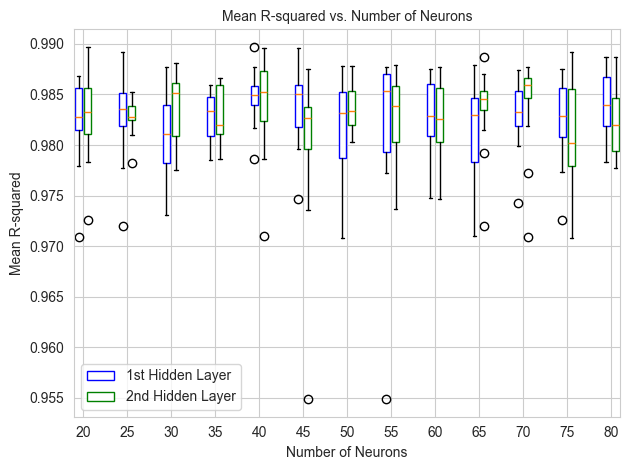

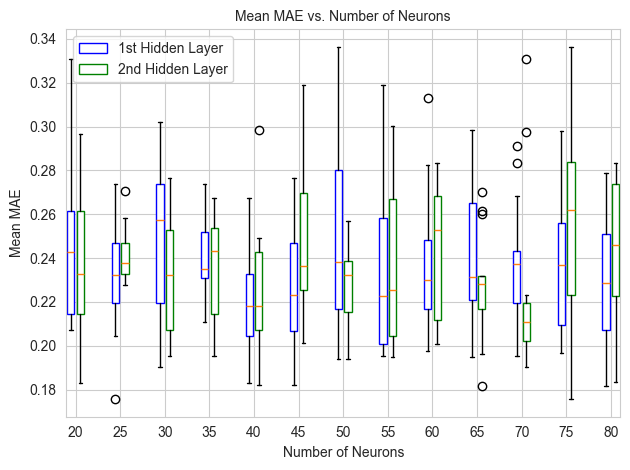

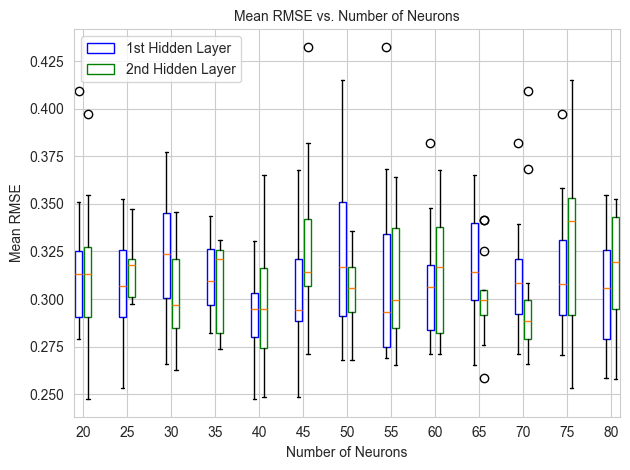

In [15]:
# Plot Mean R-squared against neurons
width = 0.8
positions_1hl = np.arange(min_neurons, max_neurons + 1, step) - width/1.5
box1 = plt.boxplot([results_df['Mean R-squared'].loc[results_df['Neurons_1HL'] == neurons] for neurons in range(min_neurons, max_neurons + 1, step)],
                   positions=positions_1hl,
                   widths=width,
                   patch_artist=True,
                   boxprops=dict(color='blue', facecolor='white'),
                   whiskerprops=dict(color='black'))
positions_2hl = np.arange(min_neurons, max_neurons + 1, step) + width/1.5
box2 = plt.boxplot([results_df['Mean R-squared'].loc[results_df['Neurons_2HL'] == neurons] for neurons in range(min_neurons, max_neurons + 1, step)],
                   positions=positions_2hl,
                   widths=width,
                   patch_artist=True,
                   boxprops=dict(color='green', facecolor='white'),
                   whiskerprops=dict(color='black'))
plt.xticks(np.arange(min_neurons, max_neurons + 1, step), [f'{neurons}' for neurons in range(min_neurons, max_neurons + 1, step)])
plt.xlabel('Number of Neurons')
plt.ylabel('Mean R-squared')
plt.title('Mean R-squared vs. Number of Neurons', fontsize = 10)
legend_handles = [
    mpatches.Patch(facecolor='white', edgecolor='blue', linewidth=1, label='1st Hidden Layer'),
    mpatches.Patch(facecolor='white', edgecolor='green', linewidth=1, label='2nd Hidden Layer')
]
plt.legend(handles=legend_handles, loc='lower left')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Mean MAE against neurons
width = 0.8
positions_1hl = np.arange(min_neurons, max_neurons + 1, step) - width/1.5
box1 = plt.boxplot([results_df['Mean MAE'].loc[results_df['Neurons_1HL'] == neurons] for neurons in range(min_neurons, max_neurons + 1, step)],
                   positions=positions_1hl,
                   widths=width,
                   patch_artist=True,
                   boxprops=dict(color='blue', facecolor='white'),
                   whiskerprops=dict(color='black'))
positions_2hl = np.arange(min_neurons, max_neurons + 1, step) + width/1.5
box2 = plt.boxplot([results_df['Mean MAE'].loc[results_df['Neurons_2HL'] == neurons] for neurons in range(min_neurons, max_neurons + 1, step)],
                   positions=positions_2hl,
                   widths=width,
                   patch_artist=True,
                   boxprops=dict(color='green', facecolor='white'),
                   whiskerprops=dict(color='black'))
plt.xticks(np.arange(min_neurons, max_neurons + 1, step), [f'{neurons}' for neurons in range(min_neurons, max_neurons + 1, step)])
plt.xlabel('Number of Neurons')
plt.ylabel('Mean MAE')
plt.title('Mean MAE vs. Number of Neurons', fontsize = 10)
legend_handles = [
    mpatches.Patch(facecolor='white', edgecolor='blue', linewidth=1, label='1st Hidden Layer'),
    mpatches.Patch(facecolor='white', edgecolor='green', linewidth=1, label='2nd Hidden Layer')
]
plt.legend(handles=legend_handles, loc='upper left')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Mean RMSE against neurons
width = 0.8
positions_1hl = np.arange(min_neurons, max_neurons + 1, step) - width/1.5
box1 = plt.boxplot([results_df['Mean RMSE'].loc[results_df['Neurons_1HL'] == neurons] for neurons in range(min_neurons, max_neurons + 1, step)],
                   positions=positions_1hl,
                   widths=width,
                   patch_artist=True,
                   boxprops=dict(color='blue', facecolor='white'),
                   whiskerprops=dict(color='black'))
positions_2hl = np.arange(min_neurons, max_neurons + 1, step) + width/1.5
box2 = plt.boxplot([results_df['Mean RMSE'].loc[results_df['Neurons_2HL'] == neurons] for neurons in range(min_neurons, max_neurons + 1, step)],
                   positions=positions_2hl,
                   widths=width,
                   patch_artist=True,
                   boxprops=dict(color='green', facecolor='white'),
                   whiskerprops=dict(color='black'))
plt.xticks(np.arange(min_neurons, max_neurons + 1, step), [f'{neurons}' for neurons in range(min_neurons, max_neurons + 1, step)])
plt.xlabel('Number of Neurons')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE vs. Number of Neurons', fontsize = 10)
legend_handles = [
    mpatches.Patch(facecolor='white', edgecolor='blue', linewidth=1, label='1st Hidden Layer'),
    mpatches.Patch(facecolor='white', edgecolor='green', linewidth=1, label='2nd Hidden Layer')
]
plt.legend(handles=legend_handles, loc='upper left')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.tight_layout()
plt.show()